<a href="https://colab.research.google.com/github/davidcpage/Imagenette-experiments/blob/master/Pytorch_image_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we explore some networks from https://github.com/rwightman/pytorch-image-models.

### Installs

In [0]:
!python -m pip install typeguard
!python -m pip install --upgrade pillow fastprogress
!python -m pip install git+https://github.com/fastai/fastcore.git
!python -m pip install git+https://github.com/fastai/fastai2

!python -m pip install --extra-index-url https://developer.download.nvidia.com/compute/redist/cuda/10.0 nvidia-dali

UTILS = 'https://raw.githubusercontent.com/davidcpage/Imagenette-experiments/master/utils.py'
!wget $UTILS -O utils.py

!python -m pip install timm

### Imports

In [0]:
from functools import partial
import numpy as np
import torch
import torch.nn as nn
import fastai2, fastai2.callback.all
from utils import *

device = torch.device(torch.cuda.current_device())
torch.backends.cudnn.benchmark = True

def draw(model, max_levels=-1, size=None):
    if not isinstance(model, Network): model = to_network(model, max_levels=max_levels)
    return display(model.explode(max_levels).draw(size=size))

### Models

We are going to patch various ```timm.models``` with a ```to_graph``` method which represents the ```.forward()``` method of an ```nn.Module``` as a graph. This allows us to display the computation graph and do various other analyses/conversions easily. 

First here's a test function to check that the  ```.forward()``` defined by the resulting graph agrees with the original:

In [0]:
import timm
from timm.models import create_model

def test_graph(model, num_classes=10, device=device):
    model = model.to(device)
    rand_batch = torch.randn((32,3,224,224), device=device)
    outputs = []
    for m in [model, Network(model).explode()]:
        torch.cuda.manual_seed(123) #set seed so that dropout behaves the same in both runs     
        outputs.append(m(rand_batch))
    assert torch.abs(outputs[0]-outputs[1]).sum().item() == 0.

#### ResNet

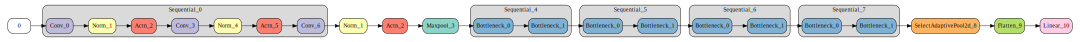

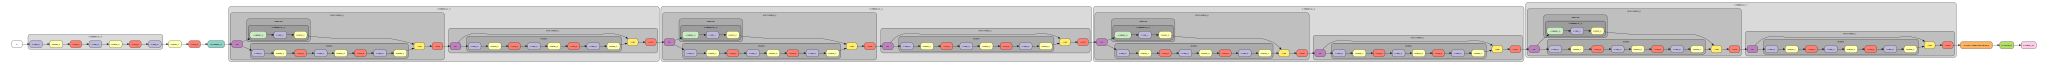

In [5]:
@to_graph.register(timm.models.resnet.ResNet)
def f(self):
    dropout = nn.Dropout(p=self.drop_rate) if self.drop_rate else None
    return to_graph(sequential([
        self.conv1, self.bn1, self.relu, self.maxpool,
        self.layer1, self.layer2, self.layer3, self.layer4,
        self.global_pool, fastai2.layers.Flatten(),
        dropout, self.fc
    ]))

@to_graph.register(timm.models.resnet.Bottleneck)
def f(self):
    return to_graph(SplitMerge({
        'branch': sequential([self.conv1, self.bn1, self.relu, self.conv2, self.bn2, 
                       self.relu, self.conv3, self.bn3, self.se]),
         'shortcut': sequential([self.downsample])}, Actn=self.relu
    ))

model = create_model('resnet26d', num_classes=10)
test_graph(model)
draw(model, max_levels=1)
draw(model)

#### SENet

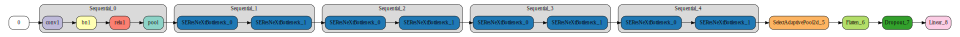

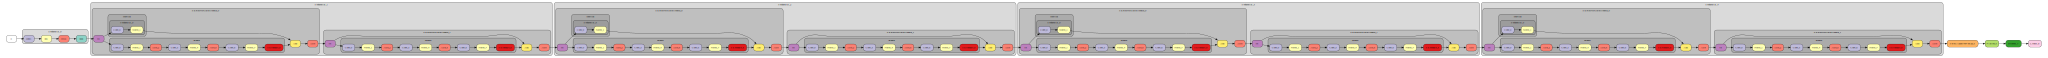

In [6]:
@to_graph.register(timm.models.senet.SENet)
def f(self):
    dropout = nn.Dropout(p=self.drop_rate) if self.drop_rate else None
    return to_graph(sequential([
        self.layer0, self.layer1, self.layer2, self.layer3, self.layer4,
        self.avg_pool, fastai2.layers.Flatten(), dropout, self.last_linear
    ]))

@to_graph.register(timm.models.senet.Bottleneck)
def f(self):
    return to_graph(SplitMerge({
        'branch': sequential([self.conv1, self.bn1, self.relu, self.conv2, self.bn2, 
                       self.relu, self.conv3, self.bn3, self.se_module]),
         'shortcut': sequential([self.downsample])}, Actn=self.relu
    ))

model = create_model('seresnext26_32x4d', num_classes=10)
test_graph(model)
draw(model, max_levels=1)
draw(model)

### GenEfficientNet

In [0]:
#nn.Sequential wants everything to be an nn.Module
class Actn(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)

class DropConnect(nn.Module):
    def __init__(self, drop_connect_rate):
        super().__init__()
        self.drop_connect_rate = drop_connect_rate
    def forward(self, x):
        return timm.models.gen_efficientnet.drop_connect(x, self.training, self.drop_connect_rate)

@to_graph.register(timm.models.gen_efficientnet.GenEfficientNet)
def f(self):
    dropout = nn.Dropout(p=self.drop_rate) if self.drop_rate > 0. else None
    act = Actn(partial(self.act_fn, inplace=True))
    if self.efficient_head:
        head = [self.global_pool, self.conv_head, act]
    else:
        head = [self.conv_head, self.bn2 if self.conv_head is not None else None, 
                act, self.global_pool]
    head += [fastai2.layers.Flatten()]
    return to_graph(sequential({
        'stem': sequential([self.conv_stem, self.bn1, act]),
        'blocks': sequential({f'block_{i}': block for i, block in self.blocks._modules.items()}),
        'head': sequential(head),
        'classfier': sequential([dropout, self.classifier])
    }))

@to_graph.register(timm.models.gen_efficientnet.InvertedResidual)
def f(self):
    act = Actn(partial(self.act_fn, inplace=True))
    shuffle = self.shuffle if self.shuffle_type == 'mid' else None
    branch = [self.conv_pw, self.bn1, act, 
              shuffle,
              self.conv_dw, self.bn2, act,
              self.se if self.has_se else None, 
              self.conv_pwl, self.bn3]
    if not self.has_residual: return to_graph(sequential(branch))

    branch += [DropConnect(self.drop_connect_rate)] if self.drop_connect_rate > 0. else []
    return to_graph(SplitMerge({
        'branch': sequential(branch), 'shortcut': sequential([])
    }))

short_names[timm.models.gen_efficientnet.InvertedResidual] = 'InvResidual'

@to_graph.register(timm.models.gen_efficientnet.DepthwiseSeparableConv)
def f(self):
    act = Actn(partial(self.act_fn, inplace=True))
    branch = [self.conv_dw, self.bn1, act, 
               self.se if self.has_se else None,
               self.conv_pw, self.bn2, act if self.has_pw_act else None]
    if not self.has_residual: return to_graph(sequential(branch))
    branch += [DropConnect(self.drop_connect_rate)] if self.drop_connect_rate > 0. else []
    return to_graph(SplitMerge({
        'branch': sequential(branch), 'shortcut': sequential([])
    }))

short_names[timm.models.gen_efficientnet.DepthwiseSeparableConv] = 'Depthwise'

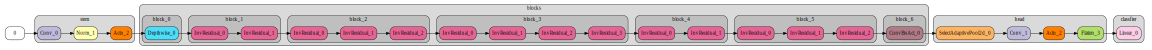

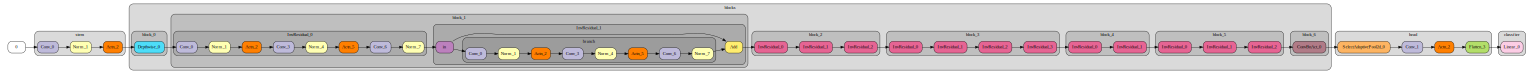

In [8]:
model = create_model('mobilenetv3_100', num_classes=10)
test_graph(model)

net = to_network(model, max_levels=2)
draw(net)

net.blocks.block_1 = to_network(net.blocks.block_1, -1)
draw(net)

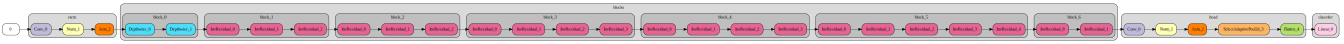

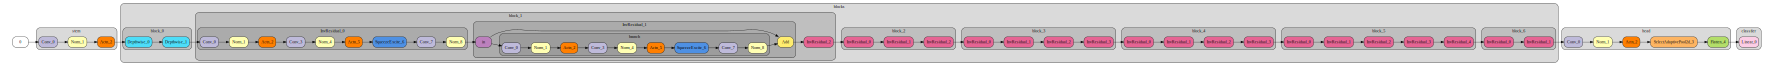

In [9]:
model = create_model('efficientnet_b2', num_classes=10)
test_graph(model)

net = to_network(model, max_levels=2)
draw(net)

net.blocks.block_1.InvResidual_0 = to_network(net.blocks.block_1.InvResidual_0, -1)
net.blocks.block_1.InvResidual_1 = to_network(net.blocks.block_1.InvResidual_1, -1)
draw(net)

### DALI DataLoaders

In [10]:
data_dir = fastai2.basics.untar_data(fastai2.basics.URLs.IMAGENETTE_320)
size = 128
bs = 64
random_aspect_ratio = (3/4, 4/3)
random_area = (0.35, 1.)
val_xtra_size = 32

to = lambda dtype: (lambda b: (b[0].to(dtype), b[1]))

train_dl = lambda folder, bs, dtype=torch.float16: (
        Map(to(dtype), DALIDataLoader(imagenet_train_graph(folder, size, random_aspect_ratio, random_area), bs, drop_last=True, device=device)))
valid_dl = lambda folder, bs, dtype=torch.float16: Chain(
        Map(to(dtype), DALIDataLoader(imagenet_valid_graph(folder, size, val_xtra_size), bs, drop_last=False, device=device)),
        Map(to(dtype), DALIDataLoader(imagenet_valid_graph(folder, size, val_xtra_size, mirror=1), bs, drop_last=False, device=device)),
    )

data = lambda data_dir=data_dir, bs=bs, dtype=torch.float16: fastai2.basics.DataBunch(train_dl(data_dir/'train', bs, dtype), valid_dl(data_dir/'val', bs, dtype))

### Training

In [0]:
learner = partial(fastai2.basics.Learner,
        metrics=[fastai2.metrics.accuracy, smoothed_acc],
        loss_func=fastai2.basics.LabelSmoothingCrossEntropy())

opt_func = partial(fastai2.basics.ranger, sqr_mom=0.99, mom=0.95, eps=1e-6, beta=0)

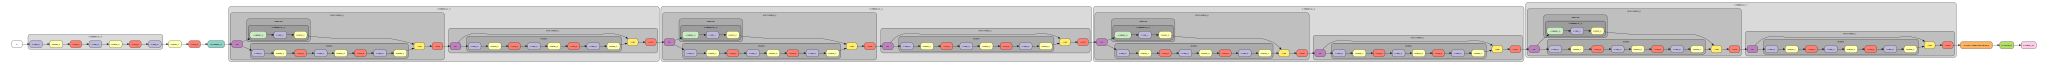

epoch,train_loss,valid_loss,accuracy,smoothed_acc,time
0,1.782034,4.887305,0.198726,0.194903,00:22
1,1.563887,1.516448,0.586369,0.564506,00:19
2,1.328598,1.425667,0.612229,0.592147,00:19
3,1.155604,1.057488,0.781019,0.759564,00:19
4,1.047078,1.019404,0.795287,0.778892,00:19


In [12]:
learn = learner(data(dtype=torch.float), create_model('resnet26d', num_classes=10), opt_func=opt_func)
draw(learn.model)
learn.fit_one_cycle(5, 8e-3)